# Sensor housing designs to mitigate the noise due to solar radiation on Ultrasonic sensor measurements

The FloodSense sensor uses ultrasonic sensing technology to calculate the depth of the floods by measuring the time difference between a transmitted ultrasonic signal and it's echo reflected back from the surface in focus.

The speed of sound in air increases by about 0.6 meters per second, per degree centigrade. Because of this, each ultrasonic sensor, HRXL MaxSonar-WR, is equipped with an internal temperature sensor which allows the sensor to apply compensation for speed of sound changes. 

However, due to the direct sunlight on the sensor itself during the daytime, there is a notable noise observed in the ultrasonic sensor readings. Even though this particular sensor model has internal temperature compensation, there is still drift in the sensor readings. This can be observed from the fact that when there is direct sunlight during the day the readings are increased because the direct sunlight is raising the temperature of the sensor housing which is erroneously inflating the internal temperature of sensor reading. The internal temperature compensation algorithm is then over compensating for the inflated temperature and returning an increased distance measure.

## Original Rectangular housing:

<img src="img/street-mounted.png" width="360" >

The cone sticking out on the bottom of the rectangular housing is the ultrasonic sensor, and initially an allumini tape is mounted over the sensor in efforts to shield the solar radition and prevent it's influence on the measurements. However, significant blips were still noticed in the measurements during the daytime. Figure(a) demonstrates such noise in the sensor's raw distance readings.

In [1]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
from matplotlib.dates import DateFormatter
from dateutil import tz
%config InlineBackend.figure_format = 'retina'
#sns.set_theme(style="darkgrid")
sns.set(style="darkgrid")

In [2]:
# Loading different sensor housing designs data
df_original = pd.read_csv('data/original_out_Feb10.csv')
df_original.columns=['Time', 'original_distance']
df_original["Time"] = pd.to_datetime(df_original["Time"], format = '%Y-%m-%d %H:%M:%S', errors ='coerce')
df_original.set_index('Time', inplace=True)
df_large = pd.read_csv('data/large_out_Feb10.csv')
df_large.columns=['Time', 'large_distance']
df_large["Time"] = pd.to_datetime(df_large["Time"], format = '%Y-%m-%d %H:%M:%S', errors ='coerce')
df_large.set_index('Time', inplace=True)
df_louvered = pd.read_csv('data/louvered_out_Feb10.csv')
df_louvered.columns=['Time', 'louvered_distance']
df_louvered["Time"] = pd.to_datetime(df_louvered["Time"], format = '%Y-%m-%d %H:%M:%S', errors ='coerce')
df_louvered.set_index('Time', inplace=True)
df_inside = pd.read_csv('data/inside_out_Feb10.csv')
df_inside.columns=['Time', 'inside_distance']
df_inside["Time"] = pd.to_datetime(df_inside["Time"], format = '%Y-%m-%d %H:%M:%S', errors ='coerce')
df_inside.set_index('Time', inplace=True)

### Data Cleaning:

The raw data needs some basic cleaning to remove the anomalies-4999's are observed because of No-return of the ultrasonic pulse-in signal. This was observed rarely at random times potentially due to external interference and in winters due to reflections from snow. Furthermore, a bad network packet might cause zeroes but not observed in this dataset.

In [3]:
df_original = df_original[(df_original['original_distance']<4000) & (df_original['original_distance']!=0)]

In [4]:
df = df_original.join(df_large, how='outer').join(df_louvered, how='outer').join(df_inside, how='outer')

### Calculating depth from distance measurements:

The raw data read by the ultrasonic sensor is the distance to the surface it is measuring. During the event of a flood, the distance between the surface decreases by the amount of flood depth level. This means the usually sensor distance measurement is in the accuracy range of the height at which the sensor is installed. 

The distance readings are inverted and shifted to the height at which the sensor is fixed to calculate the depth. Assuming mean of the data is the height at the sensors are fixed, the distance readings are shifted so that the baseline is 0.

In [5]:
df["original_distance"] = df["original_distance"].apply(lambda x:((-1)*x + df["original_distance"].mean()))
df["large_distance"] = df["large_distance"].apply(lambda x:((-1)*x + df["large_distance"].mean()))
df["louvered_distance"] = df["louvered_distance"].apply(lambda x:((-1)*x + df["louvered_distance"].mean()))
df["inside_distance"] = df["inside_distance"].apply(lambda x:((-1)*x + df["inside_distance"].mean()))

df = df.rename(columns={"original_distance": "original depth", "large_distance": "large depth", "louvered_distance": "louvered depth","inside_distance": "inside depth"})

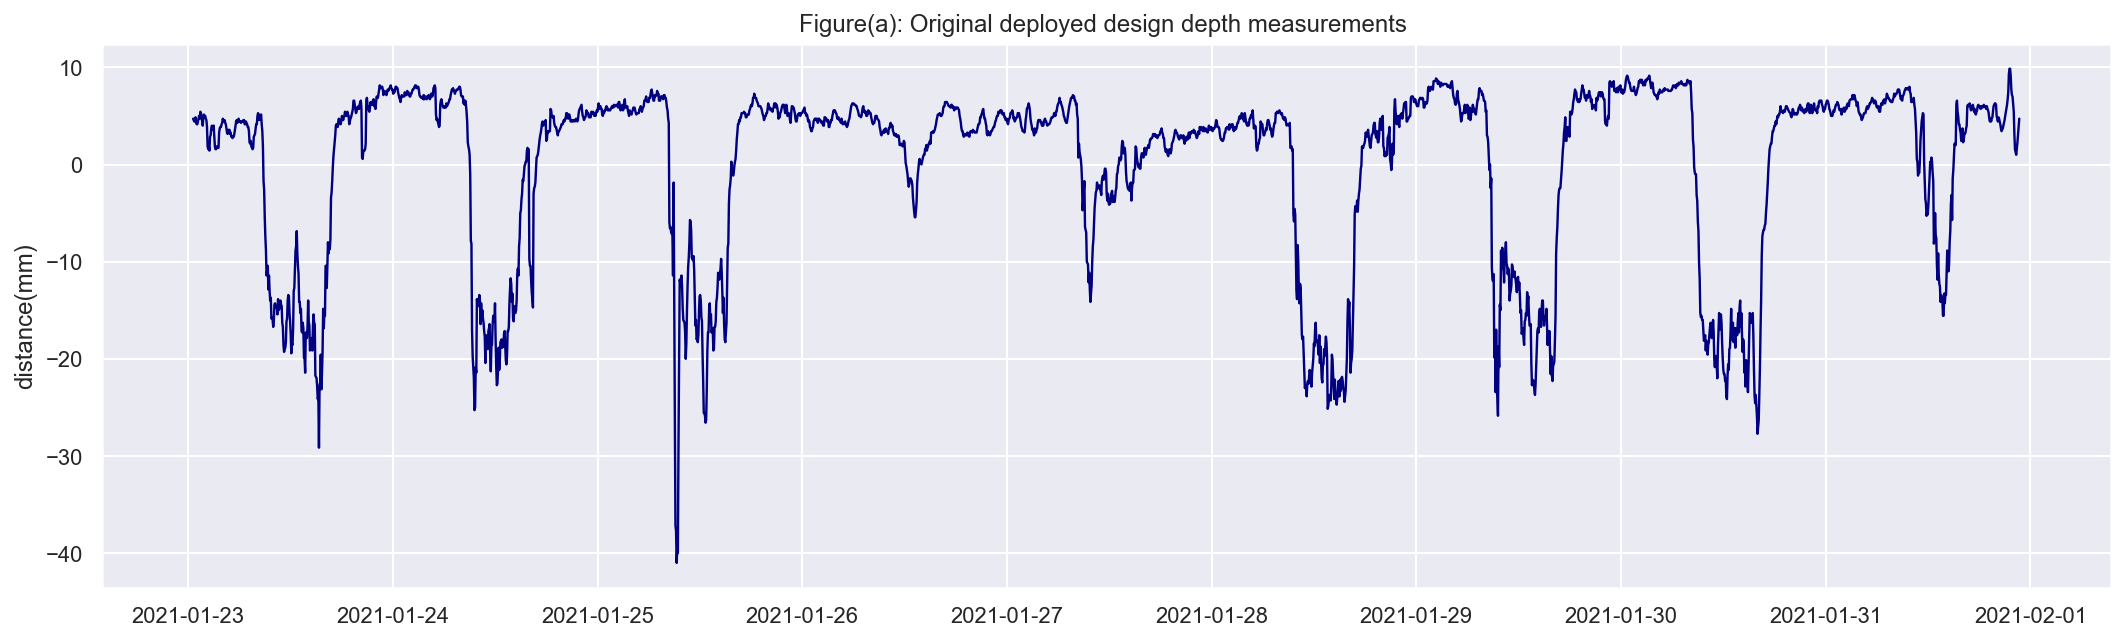

In [6]:
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(18, 5.00)
start, end = '2021-01-22', '2021-01-31'
ax1.plot(df.loc[start:end, 'original depth'].dropna().rolling(7).mean(), linestyle='-', linewidth=1.2, color='navy')
ax1.set_title('Figure(a): Original deployed design depth measurements ')
ax1.set_ylabel('distance(mm)')
plt.show()

## Housing designs to mitigate the solar influence on Ultrasonic readings:

The following three designs sheilds the ultrasonic sensor from direct sunlight and also use additional methods to mitigate the solar influence on the readings. All other components are same, except for the housing and an additional external temperature compenstaion used with the larger housing design in efforts to create an ideal environment, recommended in one of the [sensor's datasheet](https://www.maxbotix.com/documents/HRXL-MaxSonar-WRS_Datasheet.pdf).

**Larger housing design:** The Larger housing design uses a large housing which houses the original rectangular sensor to shield the complete sensor from sunlight. This design further uses a [Maxtemp](https://www.maxbotix.com/Ultrasonic_Sensors/MB7955.htm), an additional external temperature compensation for a more accurate ambient temperature calculation. Further the bottom is left open for better airflow.

**Louvered temperature shield design:** This design uses a temperature shield around the original rectangular housing's sensor cone.

**Internal Sensor design:** This design houses the ultrasonic sensor completely inside the original housing.

| Larger outer housing using Maxtemp| Louvered temperature shield | Internal Sensor |
|----------|-------------------|------------------------|
|<img src="img/larger-housing.png" width="320" >|<img src="img/Louvered-design.png" width="360" >|<img src="img/Sensor-inside.png" width="360" >|

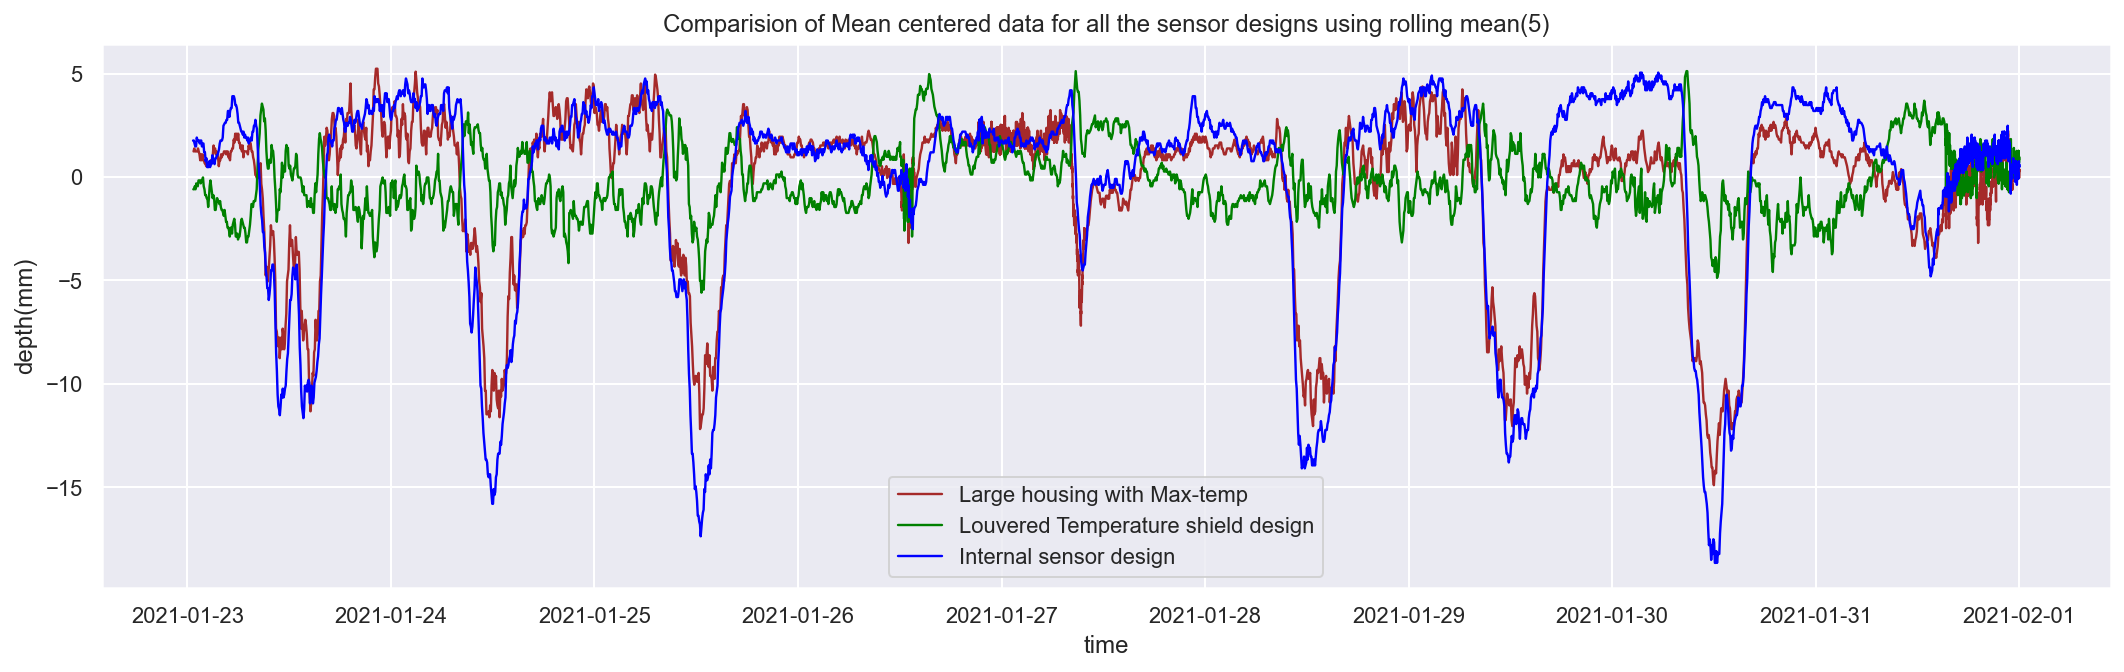

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 5.00)
start, end = '2021-01-22', '2021-01-31'
ax.plot(df.loc[start:end, 'large depth'].dropna().rolling(7).mean(), linestyle='-', linewidth=1.2, label='Large housing with Max-temp', color='brown')
ax.plot(df.loc[start:end, 'louvered depth'].dropna().rolling(7).mean(), linestyle='-', linewidth=1.2, label='Louvered Temperature shield design', color='green')
ax.plot(df.loc[start:end, 'inside depth'].dropna().rolling(7).mean(), linestyle='-', linewidth=1.2, label='Internal sensor design', color='blue')
plt.title('Comparision of Mean centered data for all the sensor designs using rolling mean(5)')
plt.xlabel('time')
plt.ylabel('depth(mm)')
ax.legend()
plt.show()

The stable regions are not centered around 0. This upward shift is due to the noise in the negative y-axis. Centering the data around the mean is not an ideal solution to calibrate the stable sensor data. Therefore, the below sections demonstrate the statistical analysis to analyze the characteristics and center the stable data at 0.

## Statistical analysis

Calculating Standard Deviation and Variance for the different sensor designs.

### Standard Deviation

In [8]:
sd_large = np.std(df["large depth"])
sd_large

3.5066421902164255

In [9]:
sd_louvered = np.std(df["louvered depth"])
sd_louvered

2.1318934257499493

In [10]:
sd_inside = np.std(df["inside depth"])
sd_inside

4.511051564739257

### Variance

In [11]:
var_large = np.var(df["large depth"])
var_large

12.296539450205849

In [12]:
var_louvered = np.var(df["louvered depth"])
var_louvered

4.544969578755854

In [13]:
var_inside = np.var(df["inside depth"])
var_inside

20.3495862197365

| | Larger outer housing using [Maxtemp](https://www.maxbotix.com/Ultrasonic_Sensors/MB7955.htm)| Louvered temperature shield | Internal Sensor |
|--|-------------------|------------------------|-------|
| |<img src="img/larger-housing.png" width="320" >|<img src="img/Louvered-design.png" width="360" >|<img src="img/Sensor-inside.png" width="360" >|
| **Standard Deviation** |$3.5 mm$|$2.1 mm$|$4.5 mm$|
| **Variance** |$12.3 mm^2$|$4.5 mm^2$|$20.3 mm^2$|

## Peak data Analysis:

The solar blips are more noticable when there is direct sunlight on the sensors and can be observed periodically from the data between the hours 8 am to 5 pm.

**Selecting data from 8 am to 5pm:**

In [14]:
df_peaks = df.between_time('8:00', '17:00')

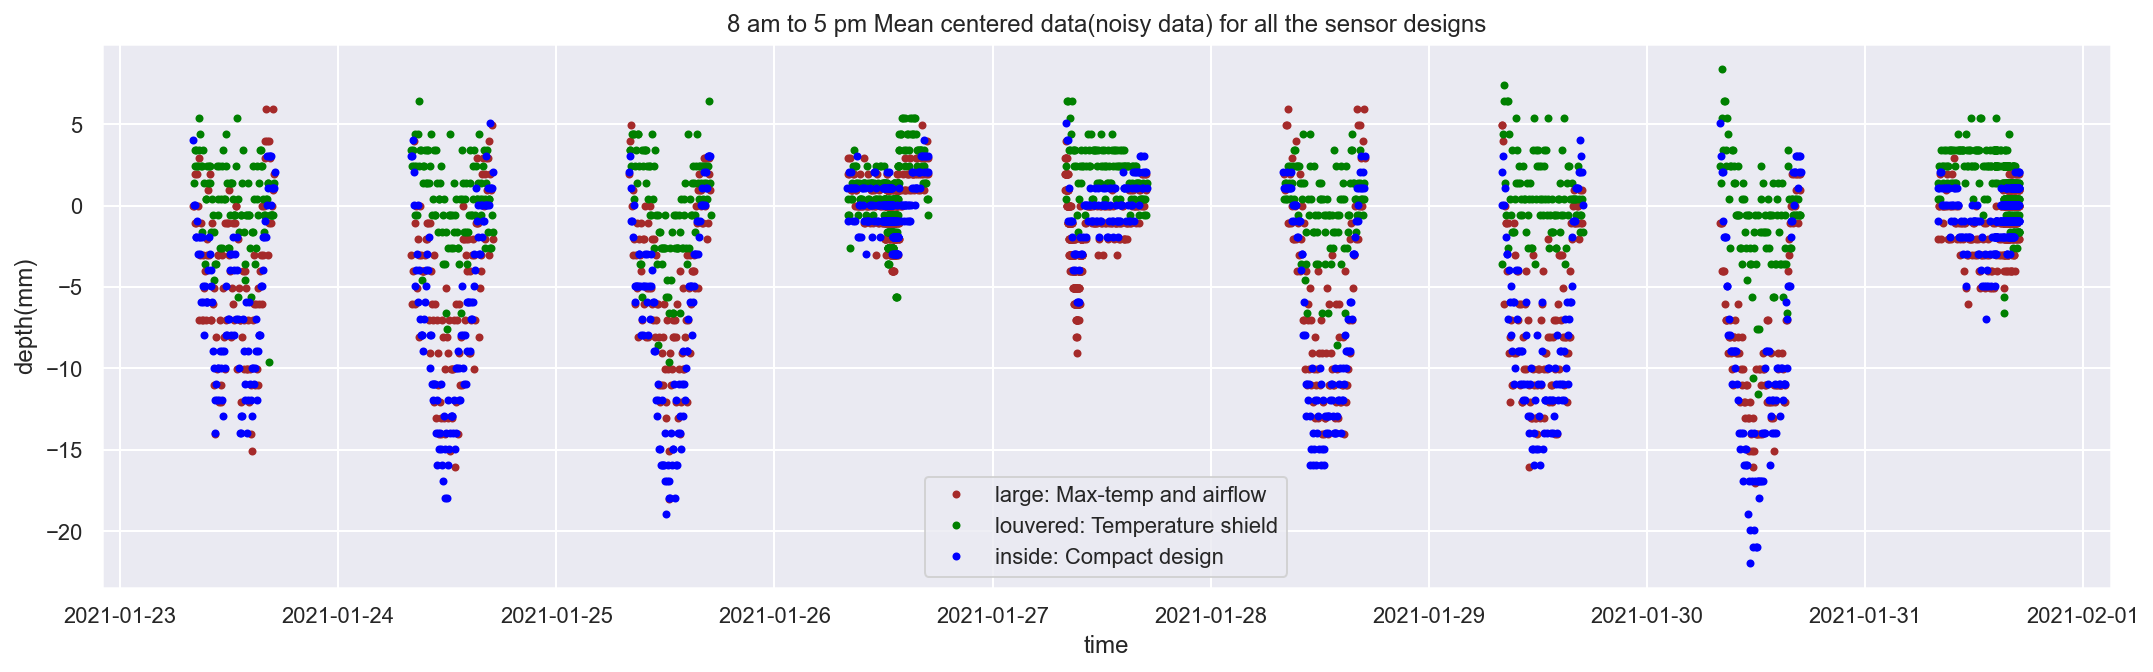

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 5.00)
start, end = '2021-01-22', '2021-01-31'
ax.plot(df_peaks.loc[start:end, 'large depth'].dropna(),'.', label='large: Max-temp and airflow', color='brown')
ax.plot(df_peaks.loc[start:end, 'louvered depth'].dropna(),'.', label='louvered: Temperature shield', color='green')
ax.plot(df_peaks.loc[start:end, 'inside depth'].dropna(),'.', label='inside: Compact design', color='blue')
plt.title('8 am to 5 pm Mean centered data(noisy data) for all the sensor designs')
plt.xlabel('time')
plt.ylabel('depth(mm)')
ax.legend()
plt.show()

The above plot shows the data between 8 am to 5 pm, where the solar influence is prevalent.

## Stable data Analysis:

In [16]:
df_stable = df.between_time('20:00', '06:00')

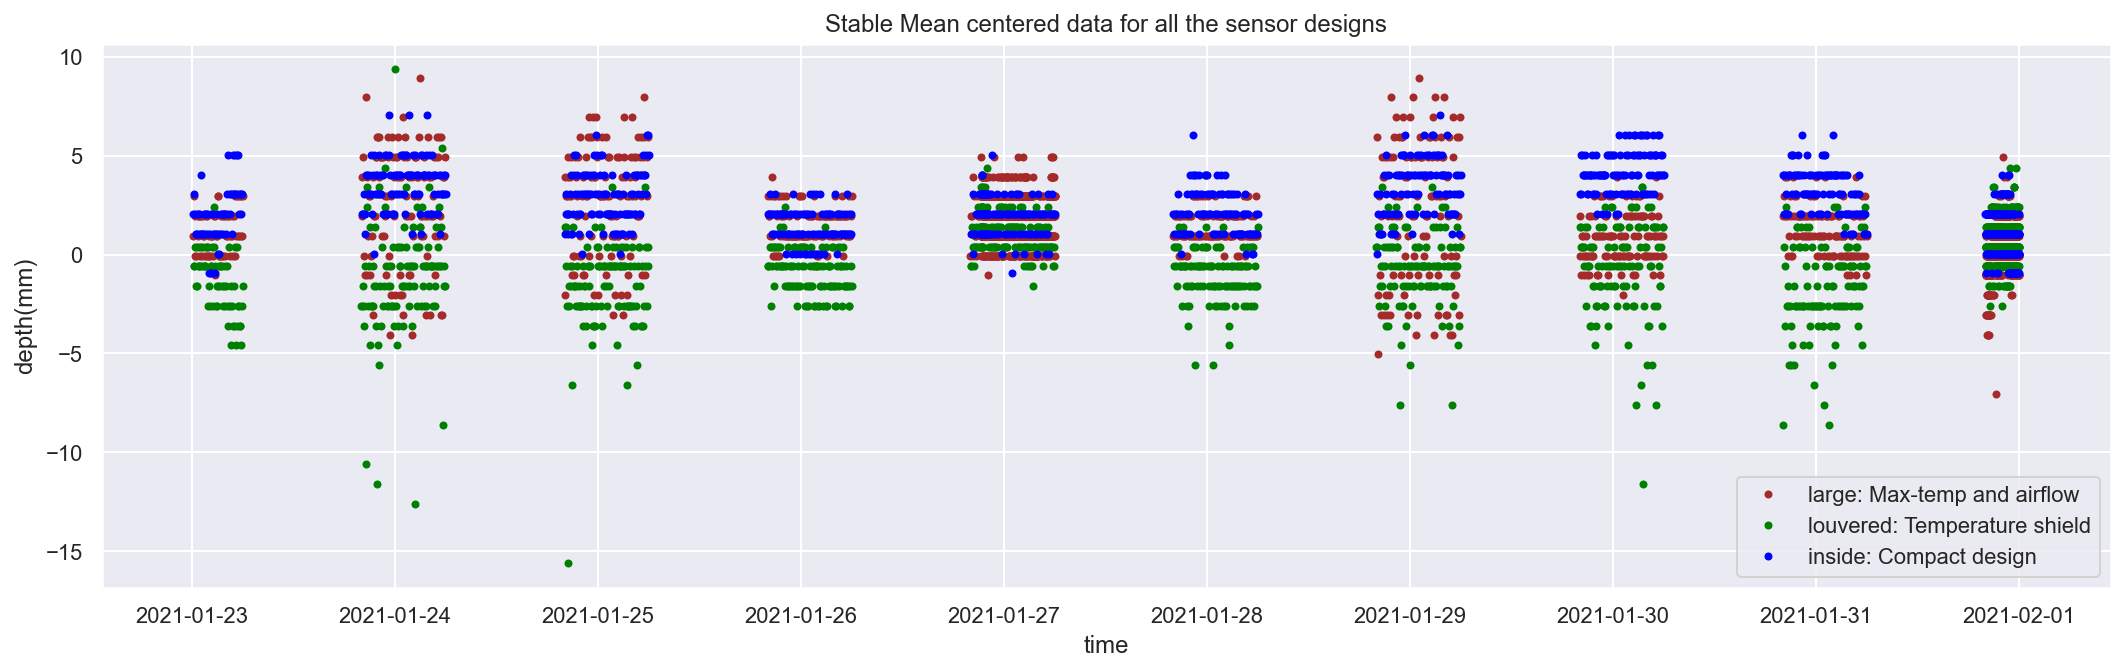

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 5.00)
start, end = '2021-01-22', '2021-01-31'
ax.plot(df_stable.loc[start:end, 'large depth'].dropna(),'.', label='large: Max-temp and airflow', color='brown')
ax.plot(df_stable.loc[start:end, 'louvered depth'].dropna(),'.', label='louvered: Temperature shield', color='green')
ax.plot(df_stable.loc[start:end, 'inside depth'].dropna(),'.', label='inside: Compact design', color='blue')
plt.title('Stable Mean centered data for all the sensor designs')
plt.xlabel('time')
plt.ylabel('depth(mm)')
ax.legend()
plt.show()

In [18]:
df_stable['large depth'].mean()

1.5023795642664095

In [19]:
df_stable['louvered depth'].mean()

-0.42326686973229666

In [20]:
df_stable['inside depth'].mean()

2.1954004031519117

The data is shifted by these stable data mean values to center the data around 0.

In [21]:
df['large depth'] = df['large depth'].apply(lambda x:x-df_stable['large depth'].mean())
df['louvered depth'] = df['louvered depth'].apply(lambda x:x-df_stable['louvered depth'].mean())
df['inside depth'] = df['inside depth'].apply(lambda x:x-df_stable['inside depth'].mean())

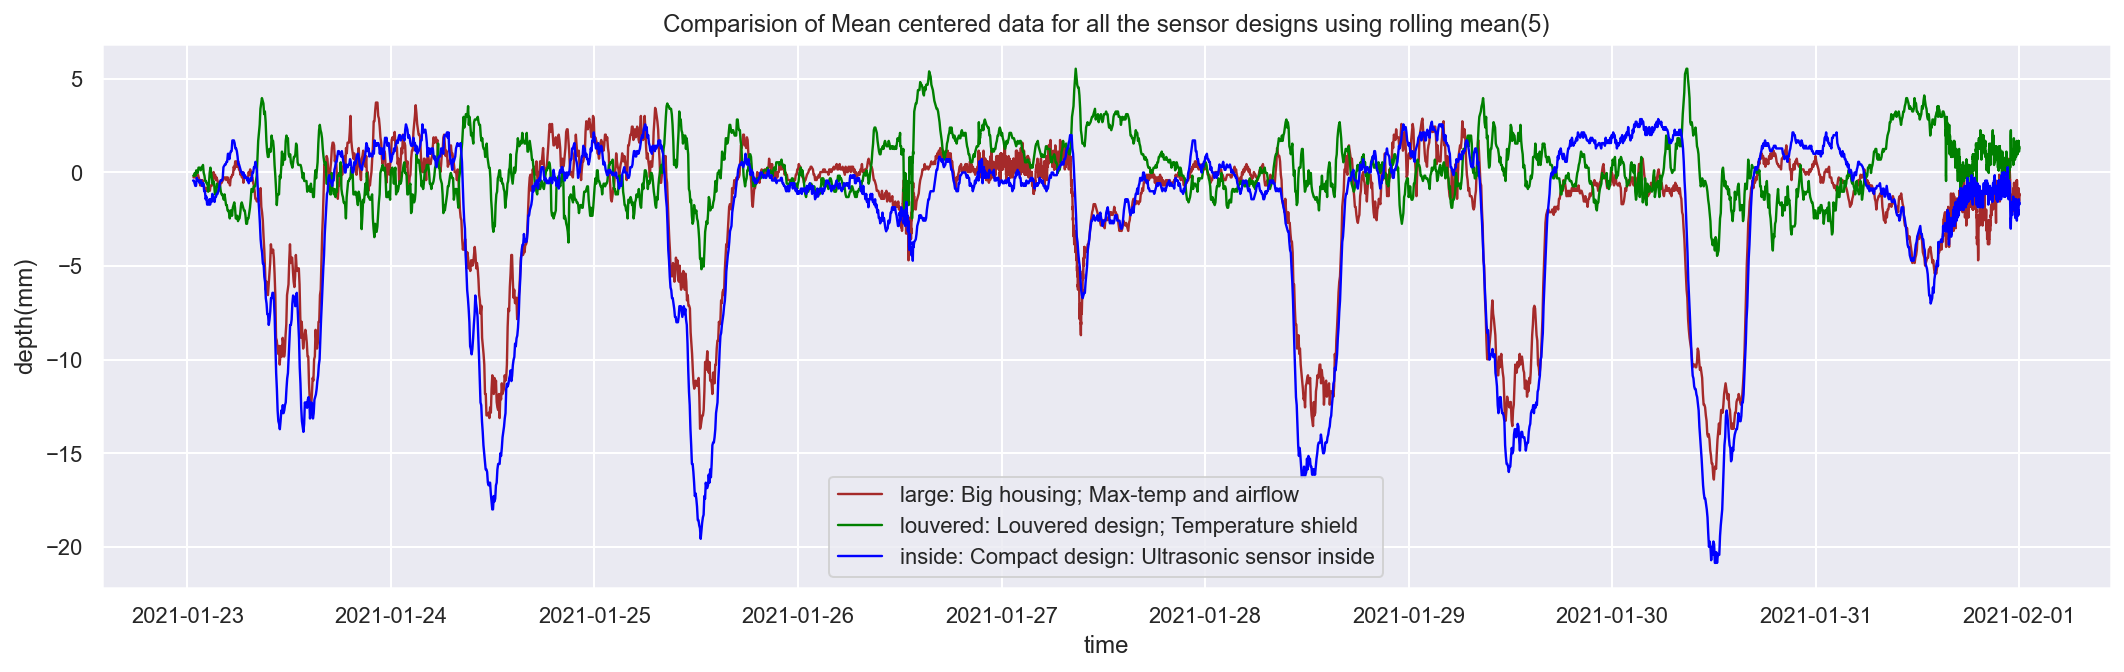

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 5.00)
start, end = '2021-01-22', '2021-01-31'
ax.plot(df.loc[start:end, 'large depth'].dropna().rolling(7).mean(), linestyle='-', linewidth=1.2, label='large: Big housing; Max-temp and airflow', color='brown')
ax.plot(df.loc[start:end, 'louvered depth'].dropna().rolling(7).mean(), linestyle='-', linewidth=1.2, label='louvered: Louvered design; Temperature shield', color='green')
ax.plot(df.loc[start:end, 'inside depth'].dropna().rolling(7).mean(), linestyle='-', linewidth=1.2, label='inside: Compact design: Ultrasonic sensor inside', color='blue')
plt.title('Comparision of Mean centered data for all the sensor designs using rolling mean(5)')
plt.xlabel('time')
plt.ylabel('depth(mm)')
ax.legend()
plt.show()

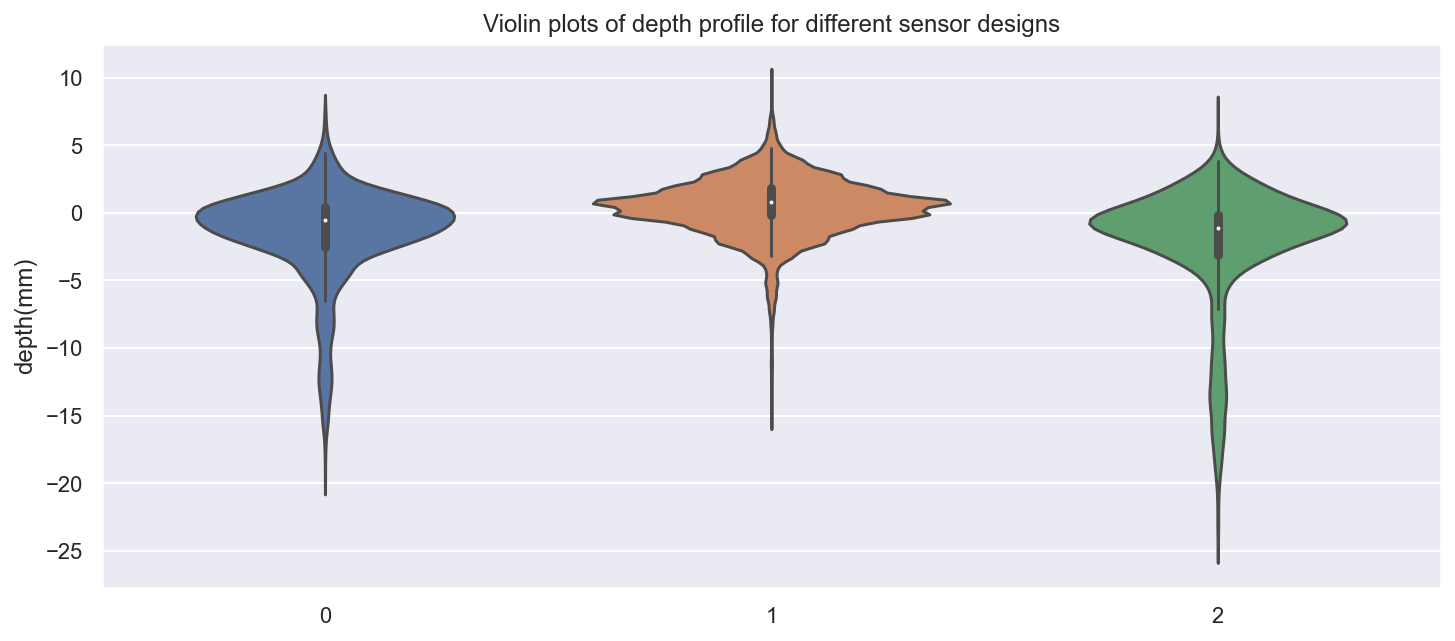

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5.00)
ax = sns.violinplot(data=[df['large depth'],df['louvered depth'],df['inside depth']])
plt.title("Violin plots of depth profile for different sensor designs")
plt.ylabel('depth(mm)')
plt.show()